In [2]:
import sys
sys.path.append("../")

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.autograd.profiler as profiler

import matplotlib.pyplot as plt
%matplotlib inline

import os
import time, gc
from progressbar import progressbar
import numpy as np
from sklearn.datasets import make_classification
from collections import defaultdict
from argparse import ArgumentDefaultsHelpFormatter, ArgumentParser

from utils.moduleCodeProfiler import rankByCriteria

In [3]:
!nvidia-smi

Wed Nov 25 14:35:29 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 455.32.00    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00004026:00:00.0 Off |                  Off |
| N/A   30C    P0    23W / 250W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
cuda0 = torch.device('cuda:0') 

In [5]:
parser = ArgumentParser(formatter_class=ArgumentDefaultsHelpFormatter)
args = parser.parse_args('')

args.data_dir = '~/datadrive'
args.dataset_dir = 'toy_mlp_1'
args.seed = 123
args.batch_size = 1000
# https://stackoverflow.com/questions/15753701/how-can-i-pass-a-list-as-a-command-line-argument-with-argparse
args.hidden_layer_dims = [5000, 5000, 5000, 5000, 5000, 5000, 5000]
args.lr = 0.01
args.epochs = 20

## Toy Data Generation

In [6]:
# construct and save toydataset

m_train = 9000
m_total = m_train

X, y = make_classification(n_samples=m_total, n_features=10, n_informative=10, n_redundant=0, n_repeated=0, n_classes=5, n_clusters_per_class=2, weights=None, flip_y=0.01, class_sep=1.0, hypercube=True, shift=0.0, scale=1.0, shuffle=True, random_state=args.seed)
# y = np.expand_dims(y, -1)

np.random.seed(args.seed)
permutation = np.random.permutation(m_total)
print('First 10 training indices', permutation[:10])
print('X shape', X.shape)
print('y shape', y.shape)

train_indices = permutation[0:m_train]

dataset_dir = 'toy_mlp_1'
os.makedirs(os.path.join(args.data_dir, dataset_dir, 'train'), mode = 0o777, exist_ok = True) 

np.save(os.path.join(args.data_dir, dataset_dir, 'train', 'features.npy'), X[train_indices])
np.save(os.path.join(args.data_dir, dataset_dir, 'train', 'labels.npy'), y[train_indices])

First 10 training indices [1603 8472 2213  498 1038 8399 3324 7535 1519 1959]
X shape (9000, 10)
y shape (9000,)


In [7]:
class ToyDataset(Dataset):
    """Toy dataset construction."""

    def __init__(self, data_dir):
        """
        Args:
            data_dir (string): Path to the directory with data files.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        # shape (m, nx)
        self.X = np.load(os.path.join(data_dir, 'features.npy'))
        # shape (m, ny=1)
        self.y = np.load(os.path.join(data_dir, 'labels.npy'))
        

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        else:
            X = torch.from_numpy(self.X[idx, :]).type(torch.FloatTensor)
            y = torch.tensor(self.y[idx], dtype=torch.long)
#             y = torch.from_numpy(self.y[idx, :]).type(torch.FloatTensor)
            sample = {'X': X, 'y': y}

        return sample

## Model

In [8]:
class MLPLazy(nn.Module):

    def __init__(self, nx, hidden_layer_dims, ny):
        super(MLPLazy, self).__init__()
        self.hidden_layer_dims = hidden_layer_dims
        
        linear_layers = []
        last_dim = nx
        for next_dim in hidden_layer_dims:
            linear_layer = nn.Linear(last_dim, next_dim)
            linear_layers.append(linear_layer)
            last_dim = next_dim
        # should push to ModuleList so that params stay on cuda
        self.linear_layers = nn.ModuleList(linear_layers)
        self.scorer = nn.Linear(last_dim, ny)

    def forward(self, X):
        '''
        X has shape (m, nx)
        '''
        last_X = X
        for i, linear_layer in enumerate(self.linear_layers):
            # shape (m, self.hidden_layer_dims[i])
            last_X = linear_layer(last_X)
            # shape (m, self.hidden_layer_dims[i])
            last_X = torch.relu(last_X)
        # shape (m, ny)
        z = self.scorer(last_X)
        # shape (m, ny)
        a = torch.softmax(z, dim=1)
        return z, a

## Timer

In [9]:
def start_timer():
    global start_time
    torch.cuda.synchronize()
    start_time = time.time()

def end_timer():
    torch.cuda.synchronize()
    end_time = time.time()
    return end_time - start_time

## Worflow

In [10]:
def check_weights_precision(model):
    '''specific to checking MLP'''
    for i, layer in enumerate(model.linear_layers):
        print(f'layer {i}, weight dtype {layer.weight.dtype}')
        print(f'layer {i}, bias dtype {layer.bias.dtype}')
    print(f'scorer weight dtype {model.scorer.weight.dtype}')
    print(f'scorer bias dtype {model.scorer.bias.dtype}')

In [11]:
def get_max_memory_alloc():
    devices_max_memory_alloc = {}
    for i in range(torch.cuda.device_count()):
        device = torch.device(f'cuda:{i}')
        devices_max_memory_alloc[f'cuda:{i}'] = torch.cuda.max_memory_allocated(device) / 1e6
        torch.cuda.reset_max_memory_allocated(device)
    return devices_max_memory_alloc

In [12]:
def main_train(args, gpu=0, debug=False):

    start_timer()
    torch.manual_seed(args.seed)
    
    ################################################################
    # load datasets
    training_set = ToyDataset(data_dir=os.path.join(args.data_dir, args.dataset_dir, 'train'))
    training_generator = torch.utils.data.DataLoader(dataset=training_set, 
                                                        batch_size=args.batch_size, 
                                                        shuffle=True, 
                                                        num_workers=0, 
                                                        pin_memory=True)

    nx = training_set.X.shape[1]
    ny = max(training_set.y) + 1
    ################################################################

    model = MLPLazy(nx, args.hidden_layer_dims, ny)  # single
    loss_criterion = nn.CrossEntropyLoss(reduction='mean')
    torch.cuda.set_device(gpu)
    model.to(device=gpu)    

    opt = torch.optim.SGD(model.parameters(), lr=args.lr)  # half
    if debug:
        print('\nmodel weights at init')
        check_weights_precision(model)

    history = {
        'epoch_train_losses': [], 'step_train_losses': [], 'max_memory_allocation':[], 
         'timing': defaultdict(int)
    }
    history['timing']['setup'] += end_timer()
    
    loop_start_time = time.time()
    
    for e in progressbar(range(5000)):
        start_timer()
        model.train()
        sum_batch_losses = torch.tensor([0.], dtype=torch.float, device=gpu)
        all_batch_losses = []
        batch_max_memory_alloc = []
        history['timing']['epoch_setup'] += end_timer()
        
        epoch_start_time = time.time()
        for batch_i, batch_data in enumerate(training_generator):
            batch_start_time = time.time()
            
            start_timer()
            batch_max_memory_alloc.append(get_max_memory_alloc()['cuda:0'])
            history['timing']['get_memory'] += end_timer()

            start_timer()
            batch_X = batch_data['X'].cuda(gpu, non_blocking=True) # single
            batch_y = batch_data['y'].cuda(gpu, non_blocking=True) # long
            history['timing']['data'] += end_timer()
            
            start_timer()
            logits, activations = model(batch_X) # single
            history['timing']['forward'] += end_timer()

            start_timer()
            loss = loss_criterion(logits, batch_y)  # single
            history['timing']['loss'] += end_timer()
            
            start_timer()
            opt.zero_grad()
            history['timing']['zero_grad'] += end_timer()
            
            start_timer()
            loss.backward()  # single
            history['timing']['backward'] += end_timer()
            
            start_timer()
            opt.step()
            history['timing']['opt_step'] += end_timer()
            
            start_timer()
            sum_batch_losses += loss
            all_batch_losses.append(loss)
            history['timing']['append_losses'] += end_timer()
            
            history['timing']['batch_time'] += time.time() - batch_start_time

        start_timer()
        num_batches = batch_i + 1.
        history['epoch_train_losses'].append(sum_batch_losses/num_batches)
        history['step_train_losses'] += all_batch_losses
        history['max_memory_allocation'] += batch_max_memory_alloc
        history['timing']['append'] += end_timer()
        
        torch.cuda.synchronize()
        history['timing']['epoch_end_time'] += time.time() - epoch_start_time
        
    torch.cuda.synchronize()
    history['timing']['loop_end_time'] += time.time() - loop_start_time
    
    start_timer()
    itemize = lambda x: [tensor_val.item() for tensor_val in x]
    history['epoch_train_losses'] = itemize(history['epoch_train_losses'])   
    history['step_train_losses'] = itemize(history['step_train_losses'])   
    history['timing']['itemize_losses'] += end_timer()

    return history, model

# Train

In [12]:
!nvidia-smi

Wed Nov 25 14:28:41 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 455.32.00    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00004026:00:00.0 Off |                  Off |
| N/A   29C    P0    23W / 250W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [13]:
all_start_time = time.time()
history, model = main_train(args, debug=True)
torch.cuda.synchronize()
print(time.time() - all_start_time)

N/A% (0 of 5000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--


model weights at init
layer 0, weight dtype torch.float32
layer 0, bias dtype torch.float32
layer 1, weight dtype torch.float32
layer 1, bias dtype torch.float32
layer 2, weight dtype torch.float32
layer 2, bias dtype torch.float32
layer 3, weight dtype torch.float32
layer 3, bias dtype torch.float32
layer 4, weight dtype torch.float32
layer 4, bias dtype torch.float32
layer 5, weight dtype torch.float32
layer 5, bias dtype torch.float32
layer 6, weight dtype torch.float32
layer 6, bias dtype torch.float32
scorer weight dtype torch.float32
scorer bias dtype torch.float32


/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/torch/cuda/memory.py:234: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  FutureWarning)
100% (5000 of 5000) |####################| Elapsed Time: 1:14:37 Time:  1:14:37


4481.872178316116


In [15]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_params

150110005

In [23]:
with profiler.profile(profile_memory=True, record_shapes=True, use_cuda=False, with_stack=True) as prof:
    with profiler.record_function("forward"):
        history, model = main_train(args, debug=True)


model weights at init
layer 0, weight dtype torch.float32
layer 0, bias dtype torch.float32
layer 1, weight dtype torch.float32
layer 1, bias dtype torch.float32
layer 2, weight dtype torch.float32
layer 2, bias dtype torch.float32
layer 3, weight dtype torch.float32
layer 3, bias dtype torch.float32
scorer weight dtype torch.float32
scorer bias dtype torch.float32


/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/torch/cuda/memory.py:234: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  FutureWarning)


# Running Time

In [15]:
# args.hidden_layer_dims = [10, 10, 10, 10, 10, 10, 10]
# 500 epochs"
history['timing']

defaultdict(int,
            {'setup': 0.033419132232666016,
             'epoch_setup': 0.05381584167480469,
             'get_memory': 2.5898804664611816,
             'data': 0.3465733528137207,
             'forward': 3.9523918628692627,
             'loss': 0.5222015380859375,
             'zero_grad': 1.9296772480010986,
             'backward': 4.9550769329071045,
             'opt_step': 1.6817753314971924,
             'append_losses': 0.136216402053833,
             'batch_time': 16.47422170639038,
             'append': 0.05046844482421875,
             'epoch_end_time': 112.07442474365234,
             'loop_end_time': 112.1322078704834,
             'itemize_losses': 0.11670160293579102})

In [16]:
# args.hidden_layer_dims = [50, 50, 50, 50, 50, 50, 50]
# 5000 epochs"
history['timing']

defaultdict(int,
            {'setup': 0.16573810577392578,
             'epoch_setup': 0.50887131690979,
             'get_memory': 34.587188959121704,
             'data': 3.297776460647583,
             'forward': 37.27410888671875,
             'loss': 4.1481773853302,
             'zero_grad': 17.538325786590576,
             'backward': 48.85865783691406,
             'opt_step': 15.545686483383179,
             'append_losses': 1.2967801094055176,
             'batch_time': 165.99205136299133,
             'append': 0.34089112281799316,
             'epoch_end_time': 1058.002289056778,
             'loop_end_time': 1058.5499851703644,
             'itemize_losses': 1.4198520183563232})

In [14]:
# args.hidden_layer_dims = [5000, 5000, 5000, 5000, 5000, 5000, 5000]
# 5000 epochs"
history['timing']

defaultdict(int,
            {'setup': 1.120006799697876,
             'epoch_setup': 1.4029920101165771,
             'get_memory': 26.92748999595642,
             'data': 3.4697084426879883,
             'forward': 1098.5500860214233,
             'loss': 5.607784986495972,
             'zero_grad': 48.409998416900635,
             'backward': 2267.143490791321,
             'opt_step': 101.99486517906189,
             'append_losses': 1.648108720779419,
             'batch_time': 3558.54425907135,
             'append': 0.38669252395629883,
             'epoch_end_time': 4471.42458486557,
             'loop_end_time': 4477.22597193718,
             'itemize_losses': 1.2950727939605713})

# Profiler Results

In [24]:
# ran for 5 epochs
rankByCriteria(prof, model, criteria='cuda_memory_usage', per_thread=False, per_inp_shapes=False, include_external=False)

Ranked by cuda_memory_usage

109.92 Mb
##############################################
model, aten::empty, forward, (26) last_X = torch.relu(last_X)
13.89 Mb
##############################################
model, aten::addmm, forward, (24) last_X = linear_layer(last_X)
6.94 Mb
##############################################
model.scorer, aten::addmm, forward, (93) return F.linear(input, self.weight, self.bias)
model, aten::addmm, forward, (24) last_X = linear_layer(last_X)
6.94 Mb
##############################################
model, aten::resize_, forward, (24) last_X = linear_layer(last_X)
6.94 Mb
##############################################
model.scorer, aten::resize_, forward, (93) return F.linear(input, self.weight, self.bias)
model, aten::resize_, forward, (24) last_X = linear_layer(last_X)
6.94 Mb
##############################################
model, aten::relu, forward, (26) last_X = torch.relu(last_X)
6.94 Mb
##############################################
model, aten::threshold

In [29]:
# ran for 5 epochs
print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))

-------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                       Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                aten::zeros         0.00%     364.803us         0.00%     699.006us     699.006us           4 b           0 b           0 b           0 b             1  
                                aten::empty        12.21%        5.508s        12.21%        5.508s      60.304us     705.43 Kb     705.43 Kb      23.58 Mb      23.58 Mb         91342  
                                aten::zero_         0.12%      54.524

In [25]:
# ran for 5 epochs
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

-------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                       Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                    forward         5.42%        2.444s        99.89%       45.063s       45.063s          -4 b      -4.46 Mb      14.79 Mb      -3.89 Mb             1  
                                   aten::to        11.57%        5.217s        37.49%       16.911s     187.679us       1.72 Mb           0 b       2.09 Mb           0 b         90105  
                                aten::stack         0.36%     163.401

In [26]:
# ran for 5 epochs
rankByCriteria(prof, model, criteria='cpu_time', per_thread=False, per_inp_shapes=False, include_external=False)

Ranked by cpu_time

124.172s
##############################################
model, aten::addmm, forward, (24) last_X = linear_layer(last_X)
226.190ms
##############################################
model.scorer, aten::addmm, forward, (93) return F.linear(input, self.weight, self.bias)
model, aten::addmm, forward, (24) last_X = linear_layer(last_X)
226.190ms
##############################################
model, aten::t, forward, (24) last_X = linear_layer(last_X)
48.934ms
##############################################
model.scorer, aten::t, forward, (93) return F.linear(input, self.weight, self.bias)
model, aten::t, forward, (24) last_X = linear_layer(last_X)
48.934ms
##############################################
model, aten::relu, forward, (26) last_X = torch.relu(last_X)
41.883ms
##############################################
model, aten::stride, forward, (24) last_X = linear_layer(last_X)
29.480ms
##############################################
model.scorer, aten::stride, forward, (93

In [28]:
# ran for 5 epochs
rankByCriteria(prof, model, criteria='cuda_time', per_thread=False, per_inp_shapes=False, include_external=False)

Ranked by cuda_time

0.000us
##############################################
model, aten::t, forward, (24) last_X = linear_layer(last_X)
0.000us
##############################################
model.scorer, aten::t, forward, (93) return F.linear(input, self.weight, self.bias)
model, aten::t, forward, (24) last_X = linear_layer(last_X)
0.000us
##############################################
model, aten::transpose, forward, (24) last_X = linear_layer(last_X)
0.000us
##############################################
model.scorer, aten::transpose, forward, (93) return F.linear(input, self.weight, self.bias)
model, aten::transpose, forward, (24) last_X = linear_layer(last_X)
0.000us
##############################################
model, aten::as_strided, forward, (24) last_X = linear_layer(last_X)
0.000us
##############################################
model.scorer, aten::as_strided, forward, (93) return F.linear(input, self.weight, self.bias)
model, aten::as_strided, forward, (24) last_X = linear_

# Training Results

In [70]:
history

{'train_losses': [1.6124650239944458,
  1.6124032735824585,
  1.6123392581939697,
  1.6122788190841675,
  1.6122169494628906,
  1.6121578216552734,
  1.6120952367782593,
  1.612037181854248,
  1.6119766235351562,
  1.6119177341461182],
 'max_memory_allocation': [0.671744,
  0.662016,
  0.667136,
  0.667648,
  0.667648,
  0.66816,
  0.66816,
  0.668672,
  0.668672,
  0.669184,
  0.669184,
  0.669696,
  0.669696,
  0.670208,
  0.670208,
  0.67072,
  0.67072,
  0.671232,
  0.671232,
  0.671744]}

Text(0.5, 1.0, '32bit')

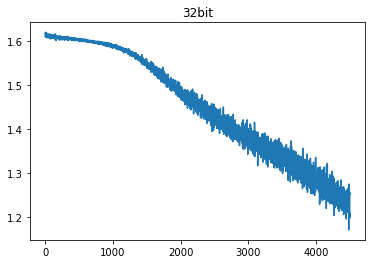

In [13]:
plt.plot(np.arange(len(history['step_train_losses'])), np.array(history['step_train_losses']))
plt.title('32bit')

Text(0.5, 1.0, '32bit')

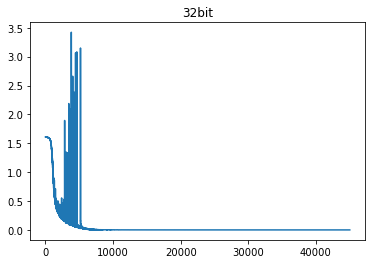

In [17]:
# args.hidden_layer_dims = [5000, 5000, 5000, 5000, 5000, 5000, 5000]
# 5000 epochs"
plt.plot(np.arange(len(history['step_train_losses'])), np.array(history['step_train_losses']))
plt.title('32bit')

Text(0.5, 1.0, '32bit')

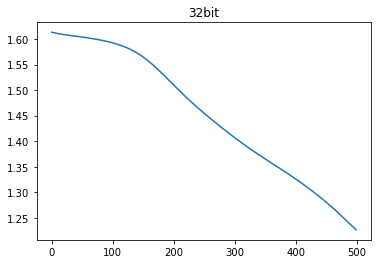

In [14]:
plt.plot(np.arange(len(history['epoch_train_losses'])), np.array(history['epoch_train_losses']))
plt.title('32bit')

Text(0.5, 1.0, '32bit')

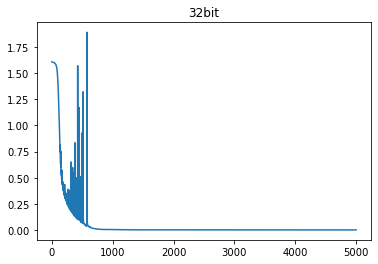

In [18]:
# args.hidden_layer_dims = [5000, 5000, 5000, 5000, 5000, 5000, 5000]
# 5000 epochs"
plt.plot(np.arange(len(history['epoch_train_losses'])), np.array(history['epoch_train_losses']))
plt.title('32bit')

Text(0.5, 1.0, '32bit')

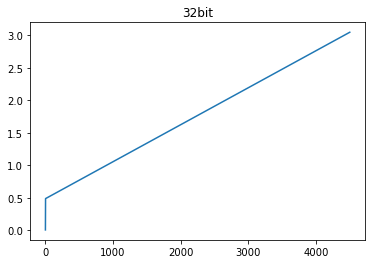

In [15]:
plt.plot(np.arange(len(history['max_memory_allocation'])), np.array(history['max_memory_allocation']))
plt.title('32bit')

Text(0.5, 1.0, '32bit')

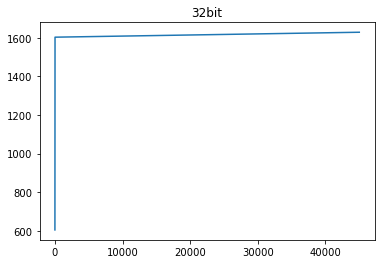

In [19]:
# args.hidden_layer_dims = [5000, 5000, 5000, 5000, 5000, 5000, 5000]
# 5000 epochs"
plt.plot(np.arange(len(history['max_memory_allocation'])), np.array(history['max_memory_allocation']))
plt.title('32bit')

# Nvidia Results

In [14]:
# Ran without profiler
!nvidia-smi

Sun Nov 22 16:31:42 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 455.32.00    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           On   | 000047DD:00:00.0 Off |                    0 |
| N/A   44C    P0    56W / 149W |    338MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [20]:
# Ran without profiler
# args.hidden_layer_dims = [5000, 5000, 5000, 5000, 5000, 5000, 5000]
# 5000 epochs"
!nvidia-smi

Wed Nov 25 15:56:02 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 455.32.00    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00004026:00:00.0 Off |                  Off |
| N/A   32C    P0    35W / 250W |   2693MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [15]:
# Ran without profiler
print(torch.cuda.memory_summary(cuda0))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |  496640 B  |  141505 KB |  141505 KB |
|       from large pool |       0 B  |       0 B  |       0 KB |       0 KB |
|       from small pool |       0 B  |  496640 B  |  141505 KB |  141505 KB |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |  496640 B  |  141505 KB |  141505 KB |
|       from large pool |       0 B  |       0 B  |       0 KB |

In [21]:
# Ran without profiler
# args.hidden_layer_dims = [5000, 5000, 5000, 5000, 5000, 5000, 5000]
# 5000 epochs"
print(torch.cuda.memory_summary(cuda0))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |    1152 MB |    1553 MB |   49947 GB |   49946 GB |
|       from large pool |    1152 MB |    1528 MB |   49922 GB |   49921 GB |
|       from small pool |       0 MB |      25 MB |      25 GB |      25 GB |
|---------------------------------------------------------------------------|
| Active memory         |    1152 MB |    1553 MB |   49947 GB |   49946 GB |
|       from large pool |    1152 MB |    1528 MB |   49922 GB |